In [1]:
import pandas as pd 
import numpy as np
import glob
import os
import math
import scipy.stats as stats
from scipy.stats import pearsonr
from sklearn.decomposition import FactorAnalysis
import pingouin as pg
import semopy
import statsmodels.api as sm
from sklearn import linear_model
from mlxtend.feature_selection import SequentialFeatureSelector
from statsmodels.multivariate.manova import MANOVA
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from scipy.stats import f_oneway, kruskal
import seaborn as sns
from statsmodels.stats.inter_rater import fleiss_kappa

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Read CSV
tam_df = pd.read_csv('/home/wb1115/VSCode_projects/cdss/cdss_1/cdss_1/tam_results/tam.csv')
demographics = pd.read_csv('/home/wb1115/VSCode_projects/cdss/cdss_1/cdss_1/demographic_results/demographics_processed.csv')

In [3]:
# Merge
tam_df = pd.merge(tam_df, demographics[['user_id', 'user_archetype', 'age_new', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']])
# Move columns 
col = tam_df.pop('q28')
tam_df.insert(23, col.name, col)
col = tam_df.pop('q29')
tam_df.insert(24, col.name, col)
# Update column names
tam_df.columns = ['user_id',
 'user_archetype',
 'ai_attitude',
 'PU1',
 'PU2',
 'PU3',
 'PU4',
 'PU5',
 'PU6',
 'PU7',
 'PU8',
 'PEOU1',
 'PU9',
 'PEOU2',
 'SE1',
 'SE2',
 'voluntary',
 'SN1',
 'SN2',
 'prestige_image',
 'PU10',
 'PU11',
 'BC1',
 'BC2',
 'BC3',
 'clinical_workflow',
 'infrastructure',
 'intention',
 'colleagues',
 'PU12',
 'final_comments',
 'age_new',
 'sex_new',
 'medical_speciality_new',
 'grade_new',
 'ai_familiarity_new']

# Get result columns 
tam_df_results = tam_df.iloc[:,2:30]

# PU

In [4]:
# PU
pu_df = tam_df_results.filter(regex='PU')
# Mean and std
pu_df.mean().mean()
pu_df.std().mean()

3.5833333333333335

0.8441656967692293

In [10]:
# Corrected item-total correlation
item_total_corr = pu_df.apply(lambda x: x.corr(pu_df.drop(columns=x.name).sum(axis=1)))
print(f"Item-Total Correlations for pu_df:\n", item_total_corr)

Item-Total Correlations for pu_df:
 PU1     0.581348
PU2     0.403797
PU3     0.600402
PU4     0.313004
PU5     0.697178
PU6     0.637888
PU7     0.798766
PU8     0.647583
PU9     0.442408
PU10    0.476784
PU11    0.441986
PU12    0.751366
dtype: float64


In [22]:
rating_counts

,1,2,3,4,5
PU1,0,0,11,24,2
PU2,0,12,10,14,1
PU3,0,3,7,20,7
PU4,1,3,6,17,10
PU5,0,4,5,22,6
PU6,0,8,10,13,6
PU7,1,6,8,16,6
PU8,0,3,8,23,3
PU9,1,7,15,12,2
PU10,0,3,20,14,0


In [20]:
# Transpose the DataFrame to make each question a row
df_transposed = pu_df.transpose()

# Determine the rating categories, assuming ratings from 1 to 5
categories = range(1, 6)  # Adjust range if your ratings differ

# Initialize a DataFrame to store the counts
rating_counts = pd.DataFrame(index=df_transposed.index, columns=categories).fillna(0)

# Count the occurrences of each rating for each question
for index, row in df_transposed.iterrows():
    for rating in categories:
        rating_counts.loc[index, rating] = sum(row == rating)

# Calculate Fleiss' kappa
kappa = fleiss_kappa(rating_counts.iloc[:2])
print("Fleiss' Kappa:", kappa)

Fleiss' Kappa: 0.04576304052743852


In [21]:
fleiss_kappa(np.array([[1,1,1], [1,1,1]]) )

-0.49999999999999994

In [11]:
# Calculate bivariate correlations between all question pairs
correlation_matrix = pu_df.corr(method='spearman')  # Spearman for ordinal data

# Print correlation matrix (optional) - explore using heatmaps for better visualization
print("Bivariate Correlations (Spearman's rank):")
print(correlation_matrix)

Bivariate Correlations (Spearman's rank):
           PU1       PU2       PU3       PU4       PU5       PU6       PU7  \
PU1   1.000000  0.126012  0.368644  0.249325  0.558114  0.463651  0.484948   
PU2   0.126012  1.000000  0.447074  0.036869  0.154506  0.276241  0.440876   
PU3   0.368644  0.447074  1.000000  0.374683  0.587071  0.583244  0.627435   
PU4   0.249325  0.036869  0.374683  1.000000  0.340684  0.231468  0.273024   
PU5   0.558114  0.154506  0.587071  0.340684  1.000000  0.591579  0.623091   
PU6   0.463651  0.276241  0.583244  0.231468  0.591579  1.000000  0.775238   
PU7   0.484948  0.440876  0.627435  0.273024  0.623091  0.775238  1.000000   
PU8   0.157194  0.542324  0.350028  0.353725  0.473246  0.354582  0.564981   
PU9   0.319065  0.224489  0.025654  0.050040  0.225966  0.395428  0.584642   
PU10  0.387388  0.216194  0.123436  0.180386  0.376256  0.135149  0.286412   
PU11  0.518605  0.212569  0.240828  0.253957  0.314664  0.237198  0.387496   
PU12  0.659212  0.2826

In [15]:
# Create df for demographic analysis
#combined_pu_df = pd.DataFrame(pu_df.mean(axis=1), columns=['pu_mean']).join(demographics[['user_archetype', 'age_new', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']])
# Create df for demographic analysis
combined_pu_df = pd.DataFrame(pu_df.mean(axis=1), columns=['pu_mean']).join(tam_df['user_id'])
combined_pu_df = combined_pu_df.merge(demographics[['user_id', 'user_archetype', 'age_new', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']])


# Imputation with Mode for categorical columns
combined_pu_df['age_new'].fillna(combined_pu_df['age_new'].mode()[0], inplace=True)
combined_pu_df['sex_new'].fillna(combined_pu_df['sex_new'].mode()[0], inplace=True)
combined_pu_df['medical_speciality_new'].fillna(combined_pu_df['medical_speciality_new'].mode()[0], inplace=True)
combined_pu_df['grade_new'].fillna(combined_pu_df['grade_new'].mode()[0], inplace=True)
combined_pu_df['ai_familiarity_new'].fillna(combined_pu_df['ai_familiarity_new'].mode()[0], inplace=True)

# Drop
combined_pu_df.drop(columns='user_id', inplace=True)

In [16]:
combined_pu_df

,pu_mean,user_archetype,age_new,sex_new,medical_speciality_new,grade_new,ai_familiarity_new
0,4.166667,a,30s,Male,Pharmacist,Other,Slightly familiar
1,3.833333,b,30s,Male,Infectious Diseases,Other,Slightly familiar
2,3.500000,a,30s,Male,Infectious Diseases,Other,Slightly familiar
3,3.833333,b,30s,Female,Infectious Diseases,Other,Not familiar
4,3.666667,a,30s,Male,Other,Consultant,Slightly familiar
5,2.833333,b,40s,Male,Other,Consultant,Moderately familiar
6,4.083333,a,40s,Male,Pharmacist,Consultant,Slightly familiar
7,3.583333,b,30s,Female,Pharmacist,Other,Moderately familiar
8,3.500000,a,30s,Female,Pharmacist,Other,Slightly familiar
9,2.750000,b,40s,Male,Microbiology,Consultant,Slightly familiar


In [17]:
# Test for normality
model = smf.ols("pu_mean ~ user_archetype + age_new + sex_new + medical_speciality_new + grade_new + ai_familiarity_new", data=combined_pu_df).fit()
shapiro_stat, shapiro_p_value = stats.shapiro(model.resid)
print(f"Shapiro test: W-statistic={shapiro_stat}, p-value={shapiro_p_value}")
stats.normaltest(model.resid)
stats.kstest(model.resid, 'norm')

# Test for vairance
# Levene's Test for user_archetype
levene_archetype_stat, levene_archetype_p_value = stats.levene(combined_pu_df['pu_mean'][combined_pu_df['user_archetype'] == 'a'],
                       combined_pu_df['pu_mean'][combined_pu_df['user_archetype'] == 'b'])
print(f"Levene's test for user_archetype: W-statistic={levene_archetype_stat}, p-value={levene_archetype_p_value}")
# Levene's Test for age_new
unique_ages = combined_pu_df['age_new'].unique()
grouped_ages = [combined_pu_df['pu_mean'][combined_pu_df['age_new'] == age] for age in unique_ages]
levene_age_stat, levene_age_p_value = stats.levene(*grouped_ages)
print(f"Levene's test for age_new: W-statistic={levene_age_stat}, p-value={levene_age_p_value}")
# Levene's Test for sex_new
levene_sex_stat, levene_sex_p_value = stats.levene(combined_pu_df['pu_mean'][combined_pu_df['sex_new'] == 'Male'],
                       combined_pu_df['pu_mean'][combined_pu_df['sex_new'] == 'Female'])
print(f"Levene's test for sex_new: W-statistic={levene_sex_stat}, p-value={levene_sex_p_value}")
# Levene's Test for medical_speciality_new
unique_medical_specialities = combined_pu_df['medical_speciality_new'].unique()
grouped_medical_specialities = [combined_pu_df['pu_mean'][combined_pu_df['medical_speciality_new'] == speciality] for speciality in unique_medical_specialities]
levene_speciality_stat, levene_speciality_p_value = stats.levene(*grouped_medical_specialities)
print(f"Levene's test for medical_speciality_new: W-statistic={levene_speciality_stat}, p-value={levene_speciality_p_value}")
# Levene's Test for grade_new
unique_grades = combined_pu_df['grade_new'].unique()
grouped_grades = [combined_pu_df['pu_mean'][combined_pu_df['grade_new'] == grade] for grade in unique_grades]
levene_grade_stat, levene_grade_p_value = stats.levene(*grouped_grades)
print(f"Levene's test for grade_new: W-statistic={levene_grade_stat}, p-value={levene_grade_p_value}")
# Levene's Test for ai_familiarity_new
unique_ais = combined_pu_df['ai_familiarity_new'].unique()
grouped_ais = [combined_pu_df['pu_mean'][combined_pu_df['ai_familiarity_new'] == ai] for ai in unique_ais]
levene_ai_stat, levene_ai_p_value = stats.levene(*grouped_ais)
print(f"Levene's test for ai_familiarity_new: W-statistic={levene_ai_stat}, p-value={levene_ai_p_value}")

if shapiro_p_value >= 0.05 and levene_archetype_p_value >=0.05 and levene_age_p_value >=0.05 and levene_sex_p_value >= 0.05 and levene_speciality_p_value >=0.05 and levene_grade_p_value >= 0.05 and levene_ai_p_value >= 0.05:
    anova_bool = True
else:
    anova_bool = False

print('\n')
print('anova_bool:', anova_bool)
print('\n')

# Perform the appropriate test
# Do anover independantly for each variable and collectivly 
if anova_bool:
    print('Collective')
    model = ols("pu_mean ~ user_archetype + age_new + sex_new + medical_speciality_new + grade_new + ai_familiarity_new", data=combined_pu_df).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    # Interpretation
    for index, row in aov_table.iterrows():
        sum_sq, df_value, f_value, pr_f = row
        print(f"ANOVA for {index}: Statistic={f_value:.4f}, p-value={pr_f:.4f}")
        if pr_f < 0.05:
            print(f"  -> The differences in {index} are statistically significant.\n")
        else:
            print(f"  -> The differences in {index} are not statistically significant.\n")

# Function to perform ANOVA
def perform_anova(df, group_var):
    groups = df.groupby(group_var)['pu_mean'].apply(list)
    stat, p_value = f_oneway(*groups)
    return stat, p_value

# Function to perform Kruskal-Wallis H test
def perform_kruskal(df, group_var):
    groups = df.groupby(group_var)['pu_mean'].apply(list)
    stat, p_value = kruskal(*groups)
    return stat, p_value

print('\nIndependant')
independent_vars = ['user_archetype', 'age_new', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']
results = {}
for var in independent_vars:
    if anova_bool:
        stat, p_value = perform_anova(combined_pu_df, var)
        test_name = 'ANOVA'
    else:
        stat, p_value = perform_kruskal(combined_pu_df, var)
        test_name = 'Kruskal-Wallis'
    results[var] = {'test': test_name, 'statistic': stat, 'p_value': p_value}

# Print the results
for var, result in results.items():
    print(f"{result['test']} for {var}: Statistic={result['statistic']:.4f}, p-value={result['p_value']:.4f}")
    if result['p_value'] < 0.05:
        print(f"  -> The differences in {var} are statistically significant.\n")
    else:
        print(f"  -> The differences in {var} are not statistically significant.\n")

Shapiro test: W-statistic=0.9666719436645508, p-value=0.41297218203544617


NormaltestResult(statistic=2.777767786200775, pvalue=0.24935345449130517)

KstestResult(statistic=0.23922507135139448, pvalue=0.0427208145860527, statistic_location=0.5194454516512055, statistic_sign=1)

Levene's test for user_archetype: W-statistic=0.27595269382391563, p-value=0.6032275909078111
Levene's test for age_new: W-statistic=1.2480409984776082, p-value=0.31448883214659473
Levene's test for sex_new: W-statistic=0.14442798541476745, p-value=0.7065954342816145
Levene's test for medical_speciality_new: W-statistic=0.07396721859842814, p-value=0.973470583829015
Levene's test for grade_new: W-statistic=4.515922010151756, p-value=0.04193065971399897
Levene's test for ai_familiarity_new: W-statistic=0.5342303012953551, p-value=0.6626148166483677


anova_bool: False



Independant
Kruskal-Wallis for user_archetype: Statistic=0.0358, p-value=0.8499
  -> The differences in user_archetype are not statistically significant.

Kruskal-Wallis for age_new: Statistic=3.4484, p-value=0.4858
  -> The differences in age_new are not statistically significant.

Kruskal-Wallis for sex_new: Statistic=0.2273, p-value=0.6335
  -> The differences in sex_new are not statistically significant.

Kruskal-Wa

Text(0.5, 1.0, 'Probability plot of regression residuals \n with R value')

<bound method Axes.set of <Axes: title={'center': 'Probability plot of regression residuals \n with R value'}, xlabel='Theoretical quantiles', ylabel='Ordered Values'>>

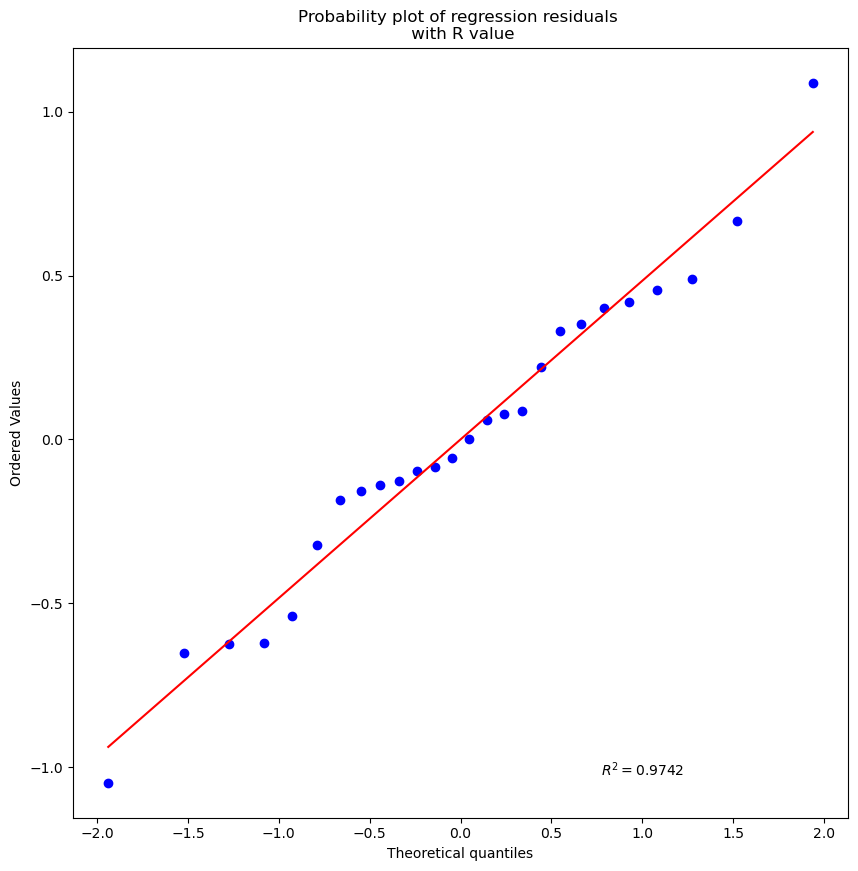

In [45]:
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(model.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of regression residuals \n with R value")
ax.set

plt.show()

In [36]:
def plot_boxplot_with_mean_median(df, cat_col, cont_col):
    plt.figure(figsize=(10, 6))
    box_plot = sns.boxplot(
        x=cat_col, y=cont_col, data=df, showmeans=True,
        boxprops=dict(facecolor="lightblue", color="lightblue"),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        flierprops=dict(markerfacecolor="black", markeredgecolor="black"),
        medianprops={"color": "darkblue", "linewidth": 2},
        meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"}
    )

    # Add legend
    handles = [
        plt.Line2D([0], [0], color='darkblue', lw=2, label='Median'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Mean')
    ]
    box_plot.legend(handles=handles, loc='lower right')

    plt.xlabel(cat_col.replace('_', ' ').title())
    plt.ylabel(cont_col.replace('_', ' ').title())
    plt.title(f'Box Plot of {cont_col.replace("_", " ").title()} by {cat_col.replace("_", " ").title()}')
    plt.xticks(rotation=45)
    plt.ylim(1, 5)
    plt.show()

/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


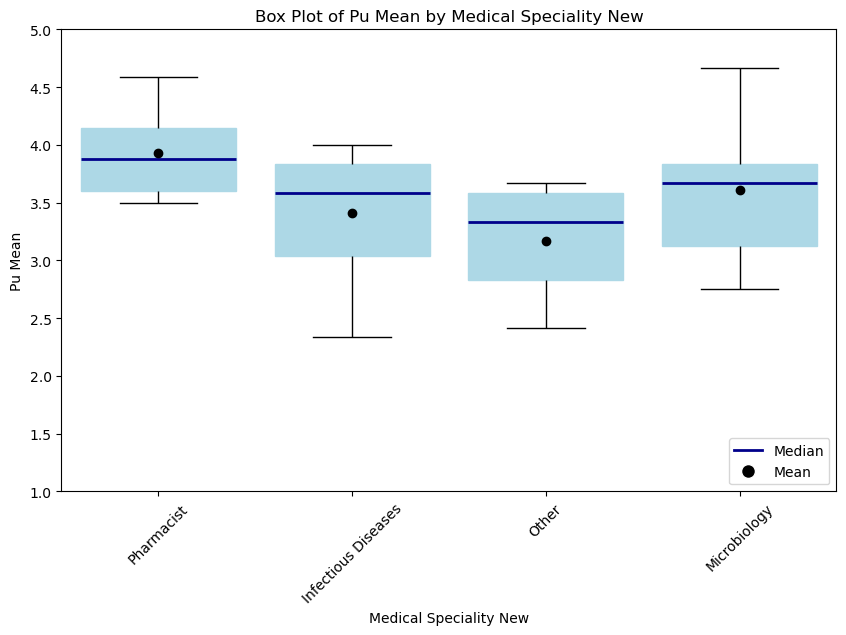

In [34]:
plot_boxplot_with_mean_median(combined_pu_df, 'medical_speciality_new', 'pu_mean')

/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


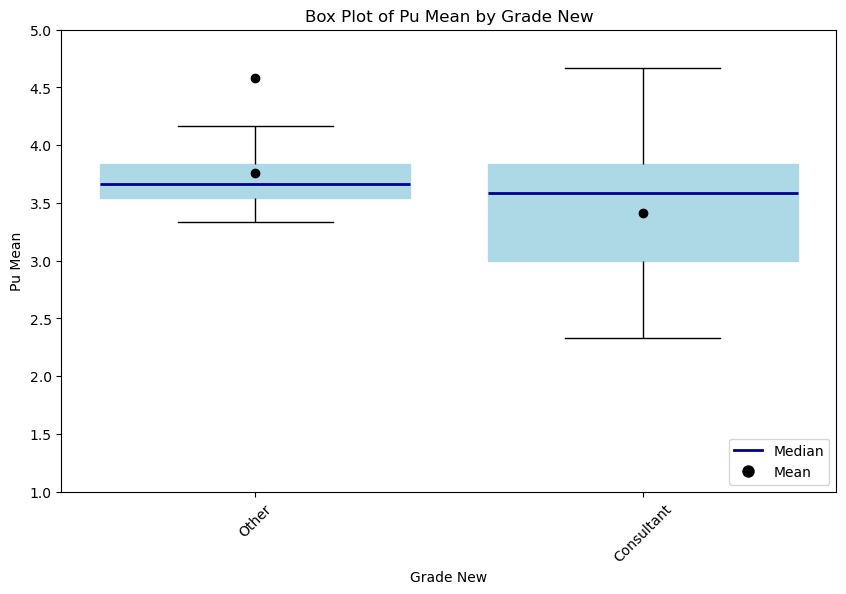

In [37]:
plot_boxplot_with_mean_median(combined_pu_df, 'grade_new', 'pu_mean')

/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


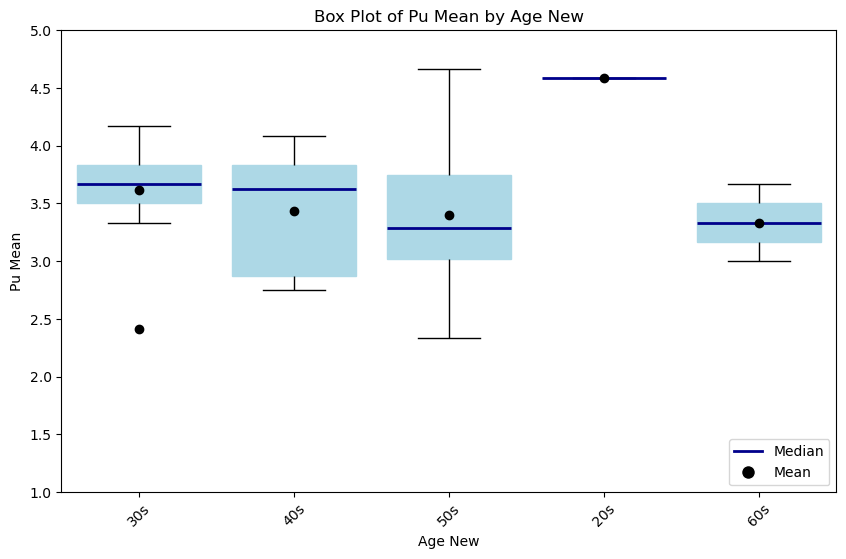

In [38]:
plot_boxplot_with_mean_median(combined_pu_df, 'age_new', 'pu_mean')

/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


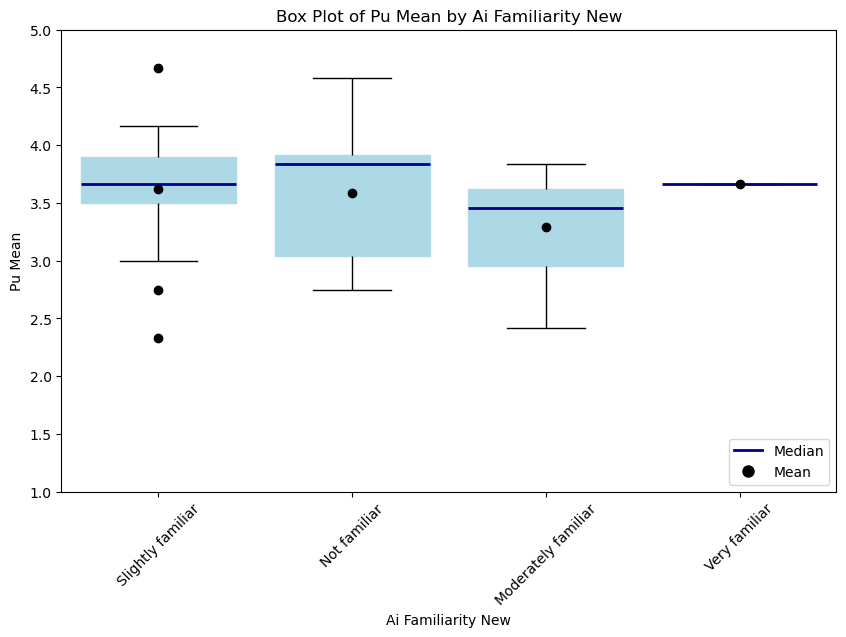

In [39]:
plot_boxplot_with_mean_median(combined_pu_df, 'ai_familiarity_new', 'pu_mean')

# Functions

In [26]:
def anover_kw_test(df, column):
    # Test for normality
    model = smf.ols(f"{column} ~ user_archetype + age_new + sex_new + medical_speciality_new + grade_new + ai_familiarity_new", data=df).fit()
    shapiro_stat, shapiro_p_value = stats.shapiro(model.resid)
    print(f"Shapiro test: W-statistic={shapiro_stat}, p-value={shapiro_p_value}")
    stats.normaltest(model.resid)
    stats.kstest(model.resid, 'norm')

    # Test for vairance
    # Levene's Test for user_archetype
    levene_archetype_stat, levene_archetype_p_value = stats.levene(df[column][df['user_archetype'] == 'a'],
                        df[column][df['user_archetype'] == 'b'])
    print(f"Levene's test for user_archetype: W-statistic={levene_archetype_stat}, p-value={levene_archetype_p_value}")
    # Levene's Test for age_new
    unique_ages = df['age_new'].unique()
    grouped_ages = [df[column][df['age_new'] == age] for age in unique_ages]
    levene_age_stat, levene_age_p_value = stats.levene(*grouped_ages)
    print(f"Levene's test for age_new: W-statistic={levene_age_stat}, p-value={levene_age_p_value}")
    # Levene's Test for sex_new
    levene_sex_stat, levene_sex_p_value = stats.levene(df[column][df['sex_new'] == 'Male'],
                        df[column][df['sex_new'] == 'Female'])
    print(f"Levene's test for sex_new: W-statistic={levene_sex_stat}, p-value={levene_sex_p_value}")
    # Levene's Test for medical_speciality_new
    unique_medical_specialities = df['medical_speciality_new'].unique()
    grouped_medical_specialities = [df[column][df['medical_speciality_new'] == speciality] for speciality in unique_medical_specialities]
    levene_speciality_stat, levene_speciality_p_value = stats.levene(*grouped_medical_specialities)
    print(f"Levene's test for medical_speciality_new: W-statistic={levene_speciality_stat}, p-value={levene_speciality_p_value}")
    # Levene's Test for grade_new
    unique_grades = df['grade_new'].unique()
    grouped_grades = [df[column][df['grade_new'] == grade] for grade in unique_grades]
    levene_grade_stat, levene_grade_p_value = stats.levene(*grouped_grades)
    print(f"Levene's test for grade_new: W-statistic={levene_grade_stat}, p-value={levene_grade_p_value}")
    # Levene's Test for ai_familiarity_new
    unique_ais = df['ai_familiarity_new'].unique()
    grouped_ais = [df[column][df['ai_familiarity_new'] == ai] for ai in unique_ais]
    levene_ai_stat, levene_ai_p_value = stats.levene(*grouped_ais)
    print(f"Levene's test for ai_familiarity_new: W-statistic={levene_ai_stat}, p-value={levene_ai_p_value}")

    if shapiro_p_value >= 0.05 and levene_archetype_p_value >=0.05 and levene_age_p_value >=0.05 and levene_sex_p_value >= 0.05 and levene_speciality_p_value >=0.05 and levene_grade_p_value >= 0.05 and levene_ai_p_value >= 0.05:
        anova_bool = True
    else:
        anova_bool = False

    print('\n')
    print('anova_bool:', anova_bool)
    print('\n')

    # Perform the appropriate test
    # Do anover independantly for each variable and collectivly 
    if anova_bool:
        print('Collective')
        model = ols(f"{column} ~ user_archetype + age_new + sex_new + medical_speciality_new + grade_new + ai_familiarity_new", data=df).fit()
        aov_table = sm.stats.anova_lm(model, typ=2)
        # Interpretation
        for index, row in aov_table.iterrows():
            sum_sq, df_value, f_value, pr_f = row
            print(f"ANOVA for {index}: Statistic={f_value:.4f}, p-value={pr_f:.4f}")
            if pr_f < 0.05:
                print(f"  -> The differences in {index} are statistically significant.\n")
            else:
                print(f"  -> The differences in {index} are ***NOT*** statistically significant.\n")

    # Function to perform ANOVA
    def perform_anova(df, group_var):
        groups = df.groupby(group_var)[column].apply(list)
        stat, p_value = f_oneway(*groups)
        return stat, p_value

    # Function to perform Kruskal-Wallis H test
    def perform_kruskal(df, group_var):
        groups = df.groupby(group_var)[column].apply(list)
        stat, p_value = kruskal(*groups)
        return stat, p_value

    print('\nIndependant')
    independent_vars = ['user_archetype', 'age_new', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']
    results = {}
    for var in independent_vars:
        if anova_bool:
            stat, p_value = perform_anova(df, var)
            test_name = 'ANOVA'
        else:
            stat, p_value = perform_kruskal(df, var)
            test_name = 'Kruskal-Wallis'
        results[var] = {'test': test_name, 'statistic': stat, 'p_value': p_value}

    # Print the results
    for var, result in results.items():
        print(f"{result['test']} for {var}: Statistic={result['statistic']:.4f}, p-value={result['p_value']:.4f}")
        if result['p_value'] < 0.05:
            print(f"  -> The differences in {var} are statistically significant.\n")
        else:
            print(f"  -> The differences in {var} are ***NOT*** statistically significant.\n")

In [21]:
def bar_plot(df, cat_col, question='TBC'):
    # Define the mapping of numbers to labels
    labels = {1: 'Strongly disagree', 2: 'Disagree', 3: 'Neither agree nor disagree', 4: 'Agree', 5: 'Strongly agree'}

    # Map the data to the labels
    data_labels = df[cat_col].map(labels)

    # Count the occurrences of each label and convert to percentages
    label_counts = data_labels.value_counts(normalize=True).reindex(labels.values(), fill_value=0) * 100

    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    bars = label_counts.plot(kind='bar', color='skyblue')
    plt.ylabel('Percentage of respondents')
    if question != 'TBC':
        plt.title(question)
    plt.xticks(rotation=45)
    plt.ylim(0, 100)  # Set the y-axis limit to 0-100%

    # Annotate bars with percentage values
    for bar in bars.patches:
        height = bar.get_height()
        plt.annotate(f'{height:.0f}%', 
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords='offset points',
                     ha='center', va='bottom')

    plt.show()

In [7]:
# Create df
updated_tam_df = tam_df.copy()
# Imputation with Mode for categorical columns
updated_tam_df['age_new'].fillna(updated_tam_df['age_new'].mode()[0], inplace=True)
updated_tam_df['sex_new'].fillna(updated_tam_df['sex_new'].mode()[0], inplace=True)
updated_tam_df['medical_speciality_new'].fillna(updated_tam_df['medical_speciality_new'].mode()[0], inplace=True)
updated_tam_df['grade_new'].fillna(updated_tam_df['grade_new'].mode()[0], inplace=True)
updated_tam_df['ai_familiarity_new'].fillna(updated_tam_df['ai_familiarity_new'].mode()[0], inplace=True)

In [8]:
updated_tam_df.columns

Index(['user_id', 'user_archetype', 'ai_attitude', 'PU1', 'PU2', 'PU3', 'PU4',
       'PU5', 'PU6', 'PU7', 'PU8', 'PEOU1', 'PU9', 'PEOU2', 'SE1', 'SE2',
       'voluntary', 'SN1', 'SN2', 'prestige_image', 'PU10', 'PU11', 'BC1',
       'BC2', 'BC3', 'clinical_workflow', 'infrastructure', 'intention',
       'colleagues', 'PU12', 'final_comments', 'age_new', 'sex_new',
       'medical_speciality_new', 'grade_new', 'ai_familiarity_new'],
      dtype='object')

# PEOU

In [37]:
# PU
peou_df = tam_df_results.filter(regex='PEOU')
# Mean and std
peou_df.mean().mean()
peou_df.std().mean()

3.828125

0.8045254784181988

In [39]:
# Create df for demographic analysis
combined_peou_df = pd.DataFrame(peou_df.mean(axis=1), columns=['peou_mean']).join(tam_df['user_id'])
combined_peou_df = combined_peou_df.merge(demographics[['user_id', 'user_archetype', 'age_new', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']])


# Imputation with Mode for categorical columns
combined_peou_df['age_new'].fillna(combined_peou_df['age_new'].mode()[0], inplace=True)
combined_peou_df['sex_new'].fillna(combined_peou_df['sex_new'].mode()[0], inplace=True)
combined_peou_df['medical_speciality_new'].fillna(combined_peou_df['medical_speciality_new'].mode()[0], inplace=True)
combined_peou_df['grade_new'].fillna(combined_peou_df['grade_new'].mode()[0], inplace=True)
combined_peou_df['ai_familiarity_new'].fillna(combined_peou_df['ai_familiarity_new'].mode()[0], inplace=True)

# Drop
combined_peou_df.drop(columns='user_id', inplace=True)

In [41]:
anover_kw_test(combined_peou_df, 'peou_mean')

Shapiro test: W-statistic=0.9718389511108398, p-value=0.5516428351402283
Levene's test for user_archetype: W-statistic=0.028462998102466792, p-value=0.8671572644414673
Levene's test for age_new: W-statistic=0.3689444892139846, p-value=0.8286078923655306
Levene's test for sex_new: W-statistic=1.8001994680851068, p-value=0.18975664493853184
Levene's test for medical_speciality_new: W-statistic=2.3766763320043496, p-value=0.0911942151369397
Levene's test for grade_new: W-statistic=0.014902456647398879, p-value=0.9036532163077966
Levene's test for ai_familiarity_new: W-statistic=0.7945908597374396, p-value=0.5072363539029758


anova_bool: True


Collective
ANOVA for user_archetype: Statistic=0.5301, p-value=0.4759
  -> The differences in user_archetype are ***NOT*** statistically significant.

ANOVA for age_new: Statistic=0.2084, p-value=0.9304
  -> The differences in age_new are ***NOT*** statistically significant.

ANOVA for sex_new: Statistic=0.4093, p-value=0.5304
  -> The differences 

# SE

Note treat separately due to low Cronbach's alpha

In [42]:
# SE
se_df = tam_df_results.filter(regex='SE')
# Mean and std
se_df.mean().mean()
se_df.std().mean()

4.0625

0.48414090829289114

4.0

0.3592106040535498

Shapiro test: W-statistic=0.8137879371643066, p-value=7.483569061150774e-05
Levene's test for user_archetype: W-statistic=0.0, p-value=1.0
Levene's test for age_new: W-statistic=2.9999999999999996, p-value=0.03598902422099518
Levene's test for sex_new: W-statistic=1.8028846153846152, p-value=0.18943611374765182
Levene's test for medical_speciality_new: W-statistic=1.8030303030303032, p-value=0.1695280679670223
Levene's test for grade_new: W-statistic=0.167910447761194, p-value=0.6848869490049643
Levene's test for ai_familiarity_new: W-statistic=0.5283018867924528, p-value=0.6665132259888265


anova_bool: False



Independant
Kruskal-Wallis for user_archetype: Statistic=0.0000, p-value=1.0000
  -> The differences in user_archetype are ***NOT*** statistically significant.

Kruskal-Wallis for age_new: Statistic=1.8878, p-value=0.7564
  -> The differences in age_new are ***NOT*** statistically significant.

Kruskal-Wallis for sex_new: Statistic=0.9841, p-value=0.3212
  -> The differences i

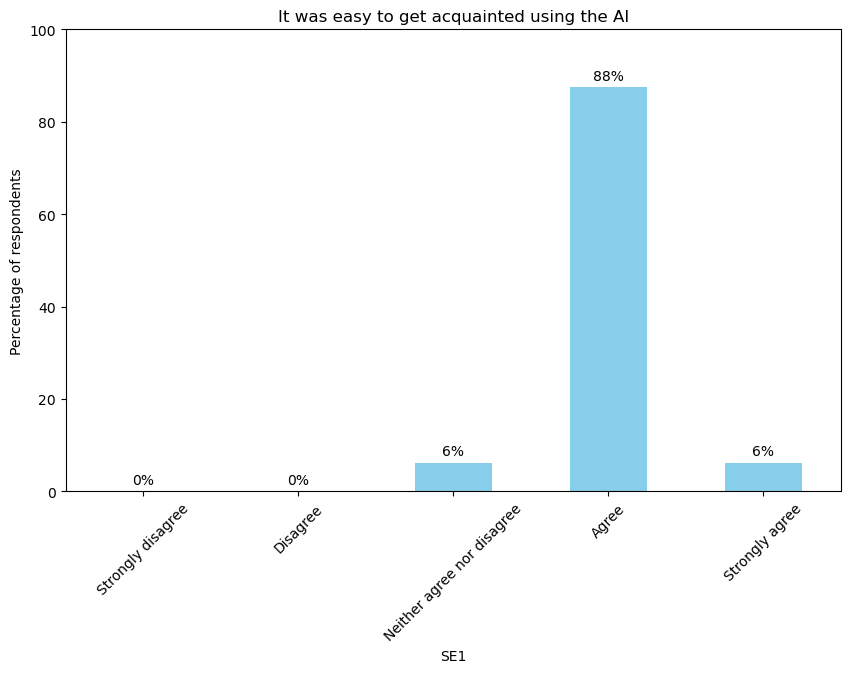

In [47]:
updated_tam_df['SE1'].mean()
updated_tam_df['SE1'].std()
anover_kw_test(updated_tam_df, 'SE1')
bar_plot(updated_tam_df, 'SE1', 'It was easy to get acquainted using the AI')

4.125

0.6090712125322324

Shapiro test: W-statistic=0.9381060600280762, p-value=0.06616336852312088
Levene's test for user_archetype: W-statistic=0.0, p-value=1.0
Levene's test for age_new: W-statistic=1.6731015358361774, p-value=0.18524981822212003
Levene's test for sex_new: W-statistic=2.8125, p-value=0.10392372192247289
Levene's test for medical_speciality_new: W-statistic=0.6970618034447821, p-value=0.5616742902506029
Levene's test for grade_new: W-statistic=0.43032786885245916, p-value=0.5168281466205649
Levene's test for ai_familiarity_new: W-statistic=1.2649812734082395, p-value=0.3054260056488501


anova_bool: True


Collective
ANOVA for user_archetype: Statistic=0.0965, p-value=0.7596
  -> The differences in user_archetype are ***NOT*** statistically significant.

ANOVA for age_new: Statistic=0.0637, p-value=0.9919
  -> The differences in age_new are ***NOT*** statistically significant.

ANOVA for sex_new: Statistic=0.7256, p-value=0.4055
  -> The differences in sex_new are ***NOT*** statistically sign

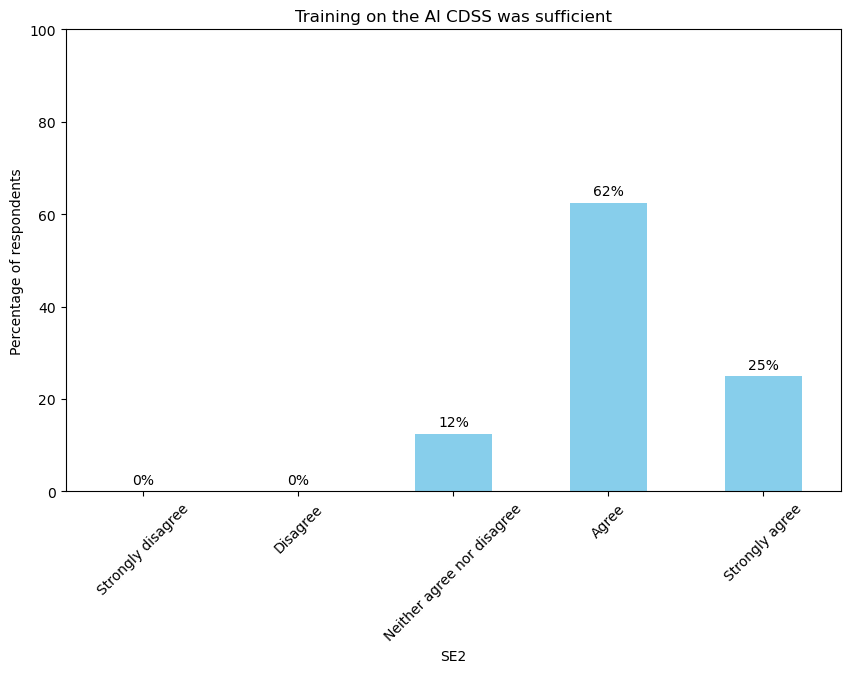

In [48]:
updated_tam_df['SE2'].mean()
updated_tam_df['SE2'].std()
anover_kw_test(updated_tam_df, 'SE2')
bar_plot(updated_tam_df, 'SE2', 'Training on the AI CDSS was sufficient')

# SN

In [49]:
# SE
sn_df = tam_df_results.filter(regex='SN')
# Mean and std
sn_df.mean().mean()
sn_df.std().mean()

3.234375

0.6764600559159754

3.34375

0.60157722803504

Shapiro test: W-statistic=0.9390539526939392, p-value=0.07038222998380661
Levene's test for user_archetype: W-statistic=0.0967741935483871, p-value=0.7578869983510859
Levene's test for age_new: W-statistic=0.6512281740159809, p-value=0.6309836555350264
Levene's test for sex_new: W-statistic=0.03832788225674564, p-value=0.846106268086225
Levene's test for medical_speciality_new: W-statistic=0.13637561952968472, p-value=0.9374805190531229
Levene's test for grade_new: W-statistic=0.09425268096514736, p-value=0.7609597881005037
Levene's test for ai_familiarity_new: W-statistic=0.35512195121951223, p-value=0.7857858961862878


anova_bool: True


Collective
ANOVA for user_archetype: Statistic=0.1867, p-value=0.6708
  -> The differences in user_archetype are ***NOT*** statistically significant.

ANOVA for age_new: Statistic=1.3532, p-value=0.2891
  -> The differences in age_new are ***NOT*** statistically significant.

ANOVA for sex_new: Statistic=0.1620, p-value=0.6921
  -> The differences i

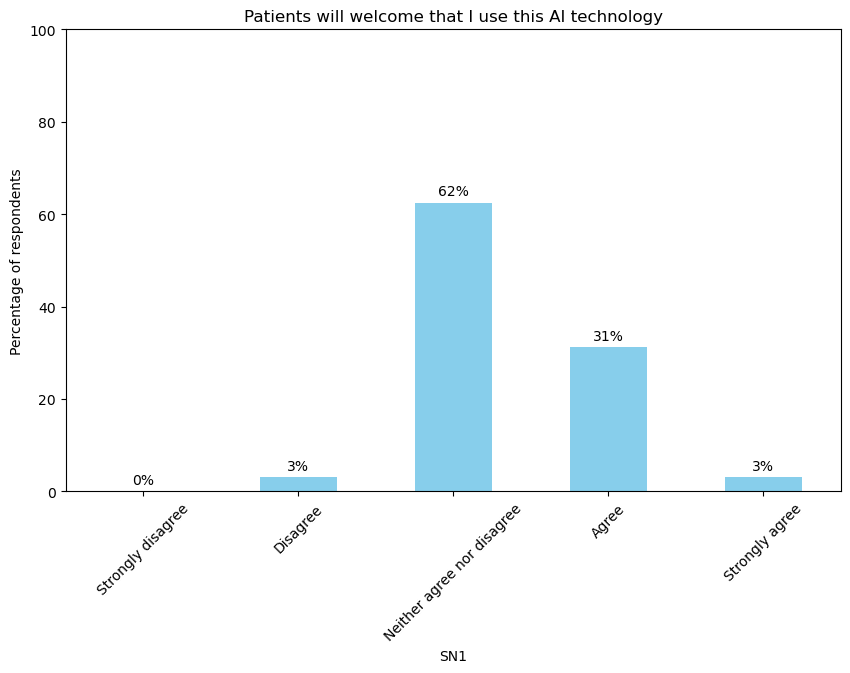

In [51]:
updated_tam_df['SN1'].mean()
updated_tam_df['SN1'].std()
anover_kw_test(updated_tam_df, 'SN1')
bar_plot(updated_tam_df, 'SN1', 'Patients will welcome that I use this AI technology')

3.125

0.7513428837969107

Shapiro test: W-statistic=0.965495765209198, p-value=0.3851791024208069
Levene's test for user_archetype: W-statistic=7.5, p-value=0.010279820529200292
Levene's test for age_new: W-statistic=0.27295703454085923, p-value=0.8928204737838561
Levene's test for sex_new: W-statistic=0.38585209003215465, p-value=0.5391793540145631
Levene's test for medical_speciality_new: W-statistic=0.3457933620024257, p-value=0.792422547119019
Levene's test for grade_new: W-statistic=0.10425716768027816, p-value=0.7490192548058903
Levene's test for ai_familiarity_new: W-statistic=0.943458251150559, p-value=0.4329118032392627


anova_bool: False



Independant
Kruskal-Wallis for user_archetype: Statistic=0.1736, p-value=0.6770
  -> The differences in user_archetype are ***NOT*** statistically significant.

Kruskal-Wallis for age_new: Statistic=6.8868, p-value=0.1420
  -> The differences in age_new are ***NOT*** statistically significant.

Kruskal-Wallis for sex_new: Statistic=3.1104, p-value=0.0778
  -> The 

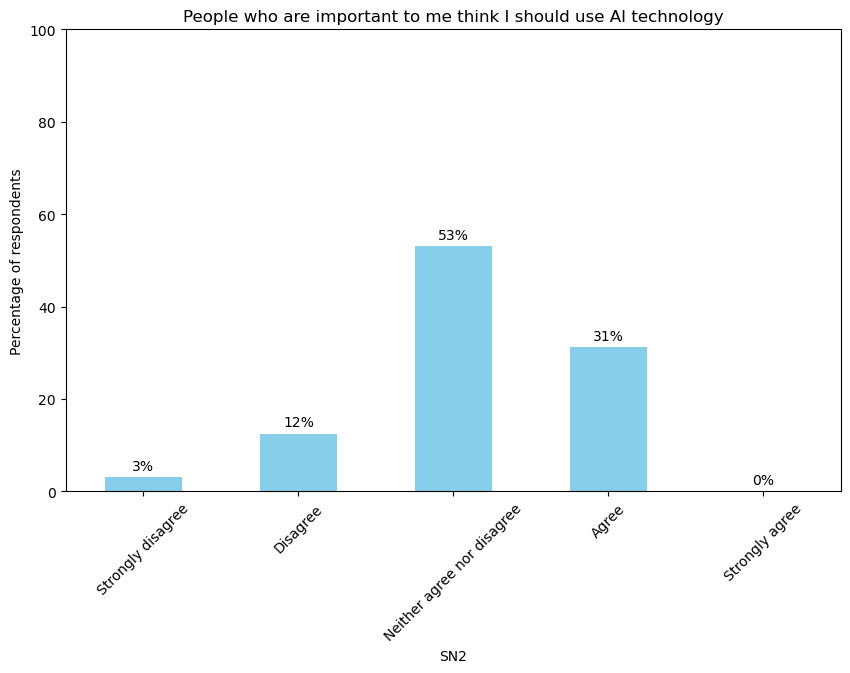

In [52]:
updated_tam_df['SN2'].mean()
updated_tam_df['SN2'].std()
anover_kw_test(updated_tam_df, 'SN2')
bar_plot(updated_tam_df, 'SN2', 'People who are important to me think I should use AI technology')

# BC

In [53]:
# BC
bc_df = tam_df_results.filter(regex='BC')
# Mean and std
bc_df.mean().mean()
bc_df.std().mean()

3.4129166666666664

0.9605826854626058

2.71875

0.9583041136265399

Shapiro test: W-statistic=0.9708852171897888, p-value=0.5241881608963013
Levene's test for user_archetype: W-statistic=0.6398104265402843, p-value=0.4300680080891579
Levene's test for age_new: W-statistic=0.6863749292686379, p-value=0.6076342289765396
Levene's test for sex_new: W-statistic=1.8399941656942815, p-value=0.18507285700558276
Levene's test for medical_speciality_new: W-statistic=0.224019342824533, p-value=0.8788849587815493
Levene's test for grade_new: W-statistic=0.3688733832539144, p-value=0.5481889663245652
Levene's test for ai_familiarity_new: W-statistic=1.0856140350877193, p-value=0.37132640088024343


anova_bool: True


Collective
ANOVA for user_archetype: Statistic=0.0070, p-value=0.9342
  -> The differences in user_archetype are ***NOT*** statistically significant.

ANOVA for age_new: Statistic=0.1701, p-value=0.9509
  -> The differences in age_new are ***NOT*** statistically significant.

ANOVA for sex_new: Statistic=2.8538, p-value=0.1084
  -> The differences in s

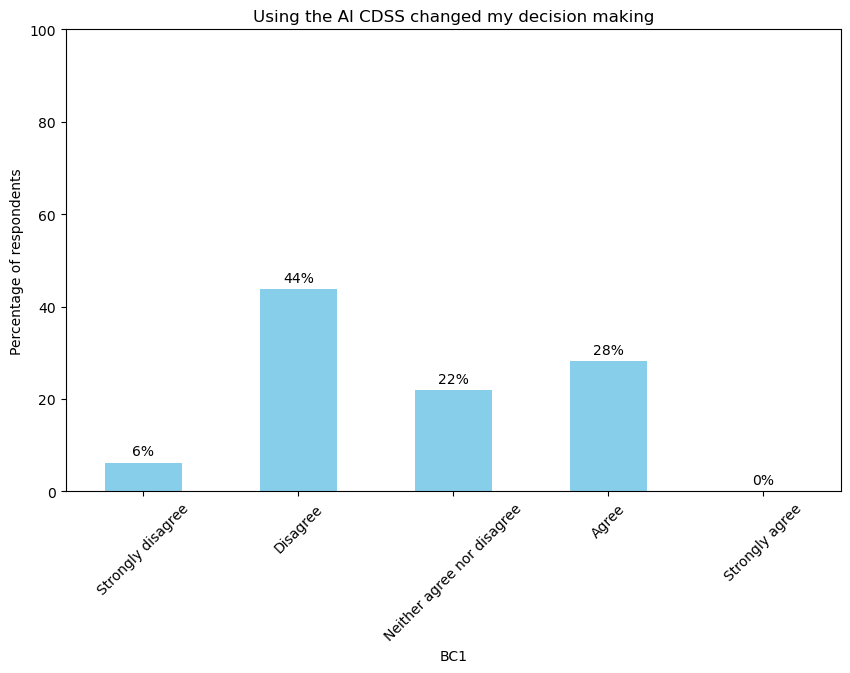

In [54]:
updated_tam_df['BC1'].mean()
updated_tam_df['BC1'].std()
anover_kw_test(updated_tam_df, 'BC1')
bar_plot(updated_tam_df, 'BC1', 'Using the AI CDSS changed my decision making')

3.88

0.971253485622231

Shapiro test: W-statistic=0.9440157413482666, p-value=0.18318240344524384
Levene's test for user_archetype: W-statistic=nan, p-value=nan
Levene's test for age_new: W-statistic=nan, p-value=nan
Levene's test for sex_new: W-statistic=nan, p-value=nan
Levene's test for medical_speciality_new: W-statistic=nan, p-value=nan
Levene's test for grade_new: W-statistic=nan, p-value=nan
Levene's test for ai_familiarity_new: W-statistic=nan, p-value=nan


anova_bool: False



Independant
Kruskal-Wallis for user_archetype: Statistic=nan, p-value=nan
  -> The differences in user_archetype are ***NOT*** statistically significant.

Kruskal-Wallis for age_new: Statistic=nan, p-value=nan
  -> The differences in age_new are ***NOT*** statistically significant.

Kruskal-Wallis for sex_new: Statistic=nan, p-value=nan
  -> The differences in sex_new are ***NOT*** statistically significant.

Kruskal-Wallis for medical_speciality_new: Statistic=nan, p-value=nan
  -> The differences in medical_speciality_new ar

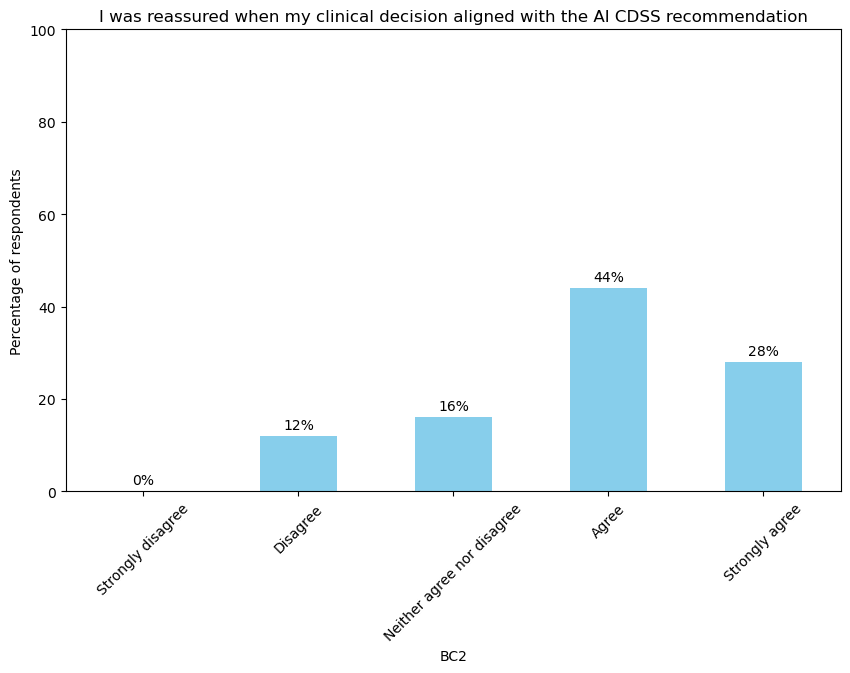

In [55]:
updated_tam_df['BC2'].mean()
updated_tam_df['BC2'].std()
anover_kw_test(updated_tam_df, 'BC2')
bar_plot(updated_tam_df, 'BC2', 'I was reassured when my clinical decision aligned with the AI CDSS recommendation')

3.64

0.9521904571390466

Shapiro test: W-statistic=0.950928807258606, p-value=0.2630804181098938
Levene's test for user_archetype: W-statistic=nan, p-value=nan
Levene's test for age_new: W-statistic=nan, p-value=nan
Levene's test for sex_new: W-statistic=nan, p-value=nan
Levene's test for medical_speciality_new: W-statistic=nan, p-value=nan
Levene's test for grade_new: W-statistic=nan, p-value=nan
Levene's test for ai_familiarity_new: W-statistic=nan, p-value=nan


anova_bool: False



Independant
Kruskal-Wallis for user_archetype: Statistic=nan, p-value=nan
  -> The differences in user_archetype are ***NOT*** statistically significant.

Kruskal-Wallis for age_new: Statistic=nan, p-value=nan
  -> The differences in age_new are ***NOT*** statistically significant.

Kruskal-Wallis for sex_new: Statistic=nan, p-value=nan
  -> The differences in sex_new are ***NOT*** statistically significant.

Kruskal-Wallis for medical_speciality_new: Statistic=nan, p-value=nan
  -> The differences in medical_speciality_new are 

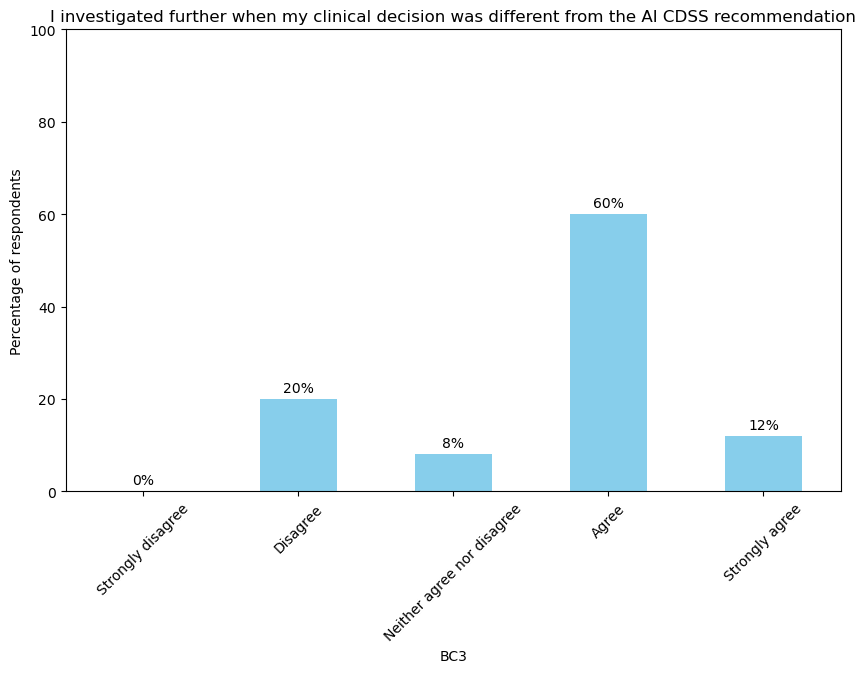

In [56]:
updated_tam_df['BC3'].mean()
updated_tam_df['BC3'].std()
anover_kw_test(updated_tam_df, 'BC3')
bar_plot(updated_tam_df, 'BC3', 'I investigated further when my clinical decision was different from the AI CDSS recommendation')

# Others

In [24]:
# ai_attitude
updated_tam_df['ai_attitude'].mean()
updated_tam_df['ai_attitude'].std()
anover_kw_test(updated_tam_df, 'ai_attitude')

3.59375

0.7120789644505048

Shapiro test: W-statistic=0.8936865329742432, p-value=0.00429396191611886
Levene's test for user_archetype: W-statistic=0.6164383561643836, p-value=0.43853070206798817
Levene's test for age_new: W-statistic=0.2550662654174573, p-value=0.9040150449258003
Levene's test for sex_new: W-statistic=0.05229083665338649, p-value=0.8206755981227041
Levene's test for medical_speciality_new: W-statistic=0.48271731690622854, p-value=0.6969585496666015
Levene's test for grade_new: W-statistic=1.450109649122806, p-value=0.23792560883289532
Levene's test for ai_familiarity_new: W-statistic=0.33437175493250254, p-value=0.8005610952858473


anova_bool: False



Independant
Kruskal-Wallis for user_archetype: Statistic=0.0389, p-value=0.8437
  -> The differences in user_archetype are ***NOT*** statistically significant.

Kruskal-Wallis for age_new: Statistic=7.5367, p-value=0.1101
  -> The differences in age_new are ***NOT*** statistically significant.

Kruskal-Wallis for sex_new: Statistic=0.7414, p-valu

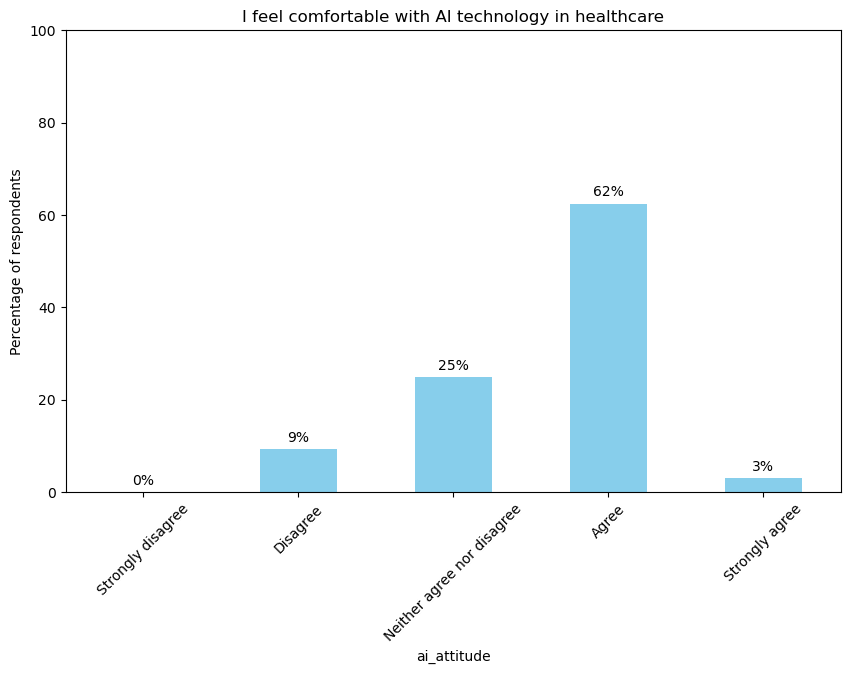

In [23]:
bar_plot(updated_tam_df, 'ai_attitude', 'I feel comfortable with AI technology in healthcare')

4.40625

0.49899091723584604

Shapiro test: W-statistic=0.969521164894104, p-value=0.4862855076789856
Levene's test for user_archetype: W-statistic=0.12195121951219512, p-value=0.7293671681475815
Levene's test for age_new: W-statistic=0.2468186211340206, p-value=0.9090647450509366
Levene's test for sex_new: W-statistic=1.839994165694282, p-value=0.18507285700558276
Levene's test for medical_speciality_new: W-statistic=0.6324891677872405, p-value=0.6002362087694577
Levene's test for grade_new: W-statistic=0.11877111486486475, p-value=0.7327755392435089
Levene's test for ai_familiarity_new: W-statistic=1.3730602110490377, p-value=0.27136965920903133


anova_bool: True


Collective
ANOVA for user_archetype: Statistic=0.0199, p-value=0.8894
  -> The differences in user_archetype are ***NOT*** statistically significant.

ANOVA for age_new: Statistic=0.2380, p-value=0.9132
  -> The differences in age_new are ***NOT*** statistically significant.

ANOVA for sex_new: Statistic=0.5092, p-value=0.4846
  -> The differences in 

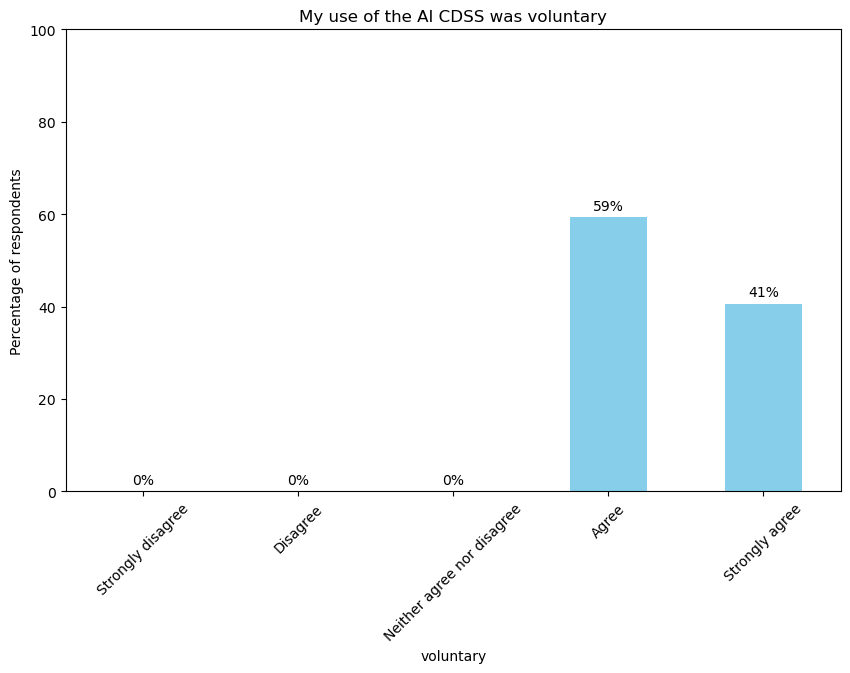

In [28]:
# voluntary
updated_tam_df['voluntary'].mean()
updated_tam_df['voluntary'].std()
anover_kw_test(updated_tam_df, 'voluntary')
bar_plot(updated_tam_df, 'voluntary', 'My use of the AI CDSS was voluntary')

3.5625

0.87758833761769

Shapiro test: W-statistic=0.9701164364814758, p-value=0.5026180744171143
Levene's test for user_archetype: W-statistic=0.2158273381294964, p-value=0.6455919607626767
Levene's test for age_new: W-statistic=0.7233715310721059, p-value=0.5836061345201107
Levene's test for sex_new: W-statistic=0.12295081967213113, p-value=0.7283061632081689
Levene's test for medical_speciality_new: W-statistic=0.8919453007667377, p-value=0.4574541540381729
Levene's test for grade_new: W-statistic=0.1829268292682927, p-value=0.6719245646010892
Levene's test for ai_familiarity_new: W-statistic=0.5268369974252327, p-value=0.6674787459329181


anova_bool: True


Collective
ANOVA for user_archetype: Statistic=2.1327, p-value=0.1614
  -> The differences in user_archetype are ***NOT*** statistically significant.

ANOVA for age_new: Statistic=0.5280, p-value=0.7167
  -> The differences in age_new are ***NOT*** statistically significant.

ANOVA for sex_new: Statistic=0.2371, p-value=0.6322
  -> The differences in s

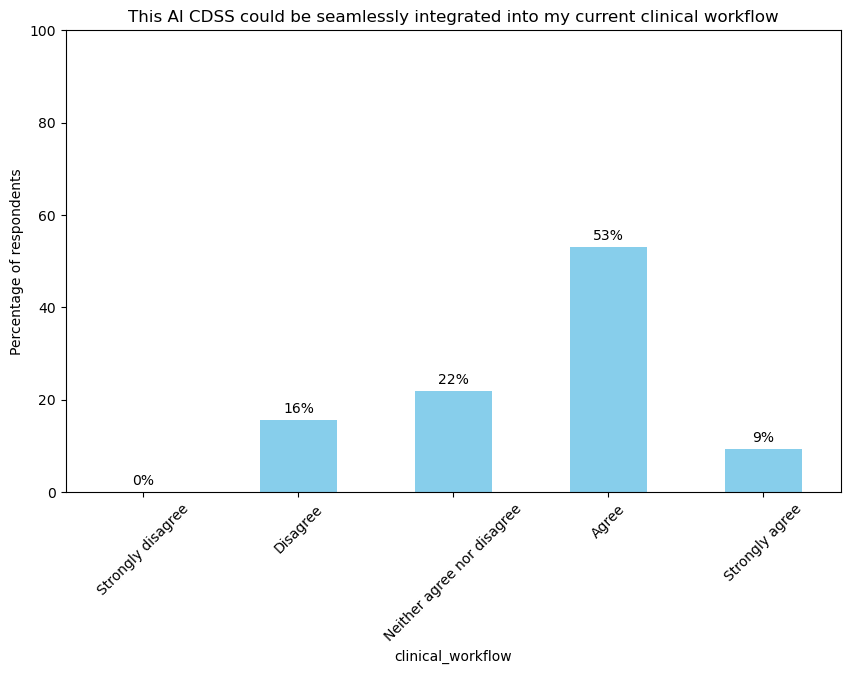

In [31]:
# clinical_workflow
updated_tam_df['clinical_workflow'].mean()
updated_tam_df['clinical_workflow'].std()
anover_kw_test(updated_tam_df, 'clinical_workflow')
bar_plot(updated_tam_df, 'clinical_workflow', 'This AI CDSS could be seamlessly integrated into my current clinical workflow')

2.6875

0.8590129369261278

Shapiro test: W-statistic=0.9704197645187378, p-value=0.5110664963722229
Levene's test for user_archetype: W-statistic=0.23809523809523808, p-value=0.6291325835941615
Levene's test for age_new: W-statistic=1.1369840213049267, p-value=0.3602121701716492
Levene's test for sex_new: W-statistic=3.500000000000001, p-value=0.07115201925913474
Levene's test for medical_speciality_new: W-statistic=0.13637561952968477, p-value=0.9374805190531229
Levene's test for grade_new: W-statistic=0.12140287769784179, p-value=0.7299512740591335
Levene's test for ai_familiarity_new: W-statistic=0.7373595505617979, p-value=0.5386233908962201


anova_bool: True


Collective
ANOVA for user_archetype: Statistic=0.0046, p-value=0.9467
  -> The differences in user_archetype are ***NOT*** statistically significant.

ANOVA for age_new: Statistic=2.2054, p-value=0.1093
  -> The differences in age_new are ***NOT*** statistically significant.

ANOVA for sex_new: Statistic=5.1865, p-value=0.0352
  -> The differences in

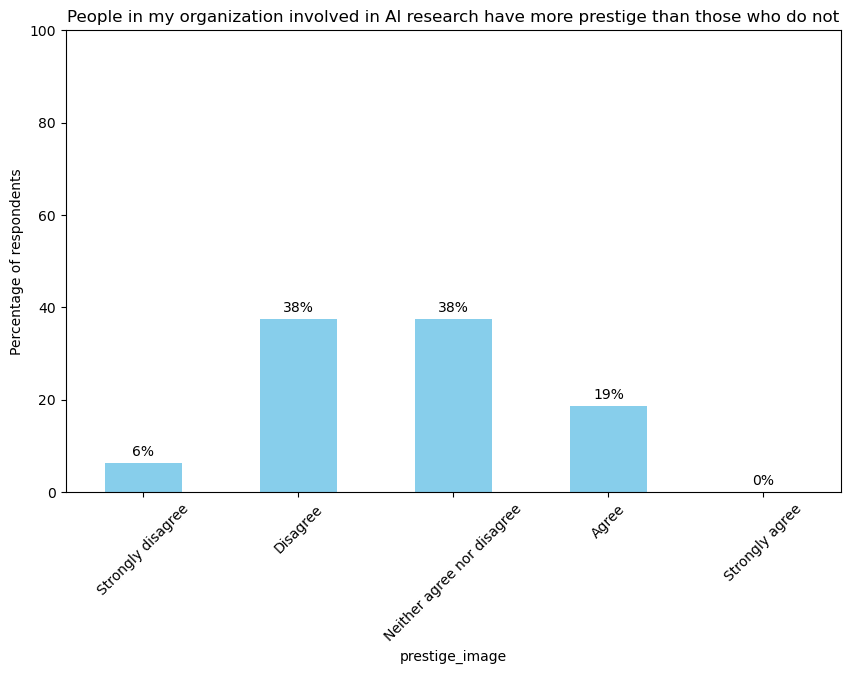

In [35]:
# prestige_image
updated_tam_df['prestige_image'].mean()
updated_tam_df['prestige_image'].std()
anover_kw_test(updated_tam_df, 'prestige_image')
bar_plot(updated_tam_df, 'prestige_image', 'People in my organization involved in AI research have more prestige than those who do not')

2.90625

0.9283830897266078

Shapiro test: W-statistic=0.9895340800285339, p-value=0.9855430126190186
Levene's test for user_archetype: W-statistic=2.4193548387096775, p-value=0.13033190001983602
Levene's test for age_new: W-statistic=1.13225519873651, p-value=0.36228615087116595
Levene's test for sex_new: W-statistic=1.6321942446043176, p-value=0.21119832099110566
Levene's test for medical_speciality_new: W-statistic=0.11783271962125201, p-value=0.9488830143081728
Levene's test for grade_new: W-statistic=0.003489454094292806, p-value=0.9532868200607401
Levene's test for ai_familiarity_new: W-statistic=0.4582256675279931, p-value=0.7136376567400785


anova_bool: True


Collective
ANOVA for user_archetype: Statistic=1.0599, p-value=0.3169
  -> The differences in user_archetype are ***NOT*** statistically significant.

ANOVA for age_new: Statistic=0.6730, p-value=0.6192
  -> The differences in age_new are ***NOT*** statistically significant.

ANOVA for sex_new: Statistic=2.2604, p-value=0.1501
  -> The differences i

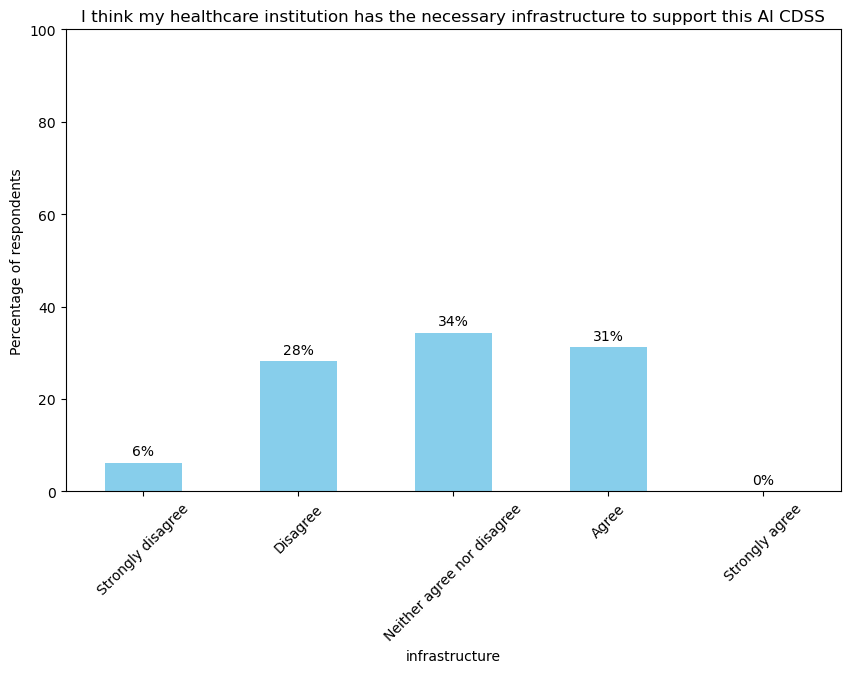

In [32]:
# infrastructure
updated_tam_df['infrastructure'].mean()
updated_tam_df['infrastructure'].std()
anover_kw_test(updated_tam_df, 'infrastructure')
bar_plot(updated_tam_df, 'infrastructure', 'I think my healthcare institution has the necessary infrastructure to support this AI CDSS')

3.75

0.762000762001143

Shapiro test: W-statistic=0.9317147731781006, p-value=0.04372555390000343
Levene's test for user_archetype: W-statistic=0.0, p-value=1.0
Levene's test for age_new: W-statistic=0.3866610695242002, p-value=0.8162456288542169
Levene's test for sex_new: W-statistic=2.9444095477386942, p-value=0.09648676120506676
Levene's test for medical_speciality_new: W-statistic=0.43243449116392446, p-value=0.731419601836257
Levene's test for grade_new: W-statistic=1.0173387096774198, p-value=0.32121758170078224
Levene's test for ai_familiarity_new: W-statistic=0.31028368794326244, p-value=0.8177522861715567


anova_bool: False



Independant
Kruskal-Wallis for user_archetype: Statistic=2.1707, p-value=0.1407
  -> The differences in user_archetype are ***NOT*** statistically significant.

Kruskal-Wallis for age_new: Statistic=4.6615, p-value=0.3238
  -> The differences in age_new are ***NOT*** statistically significant.

Kruskal-Wallis for sex_new: Statistic=0.8930, p-value=0.3447
  -> The differences i

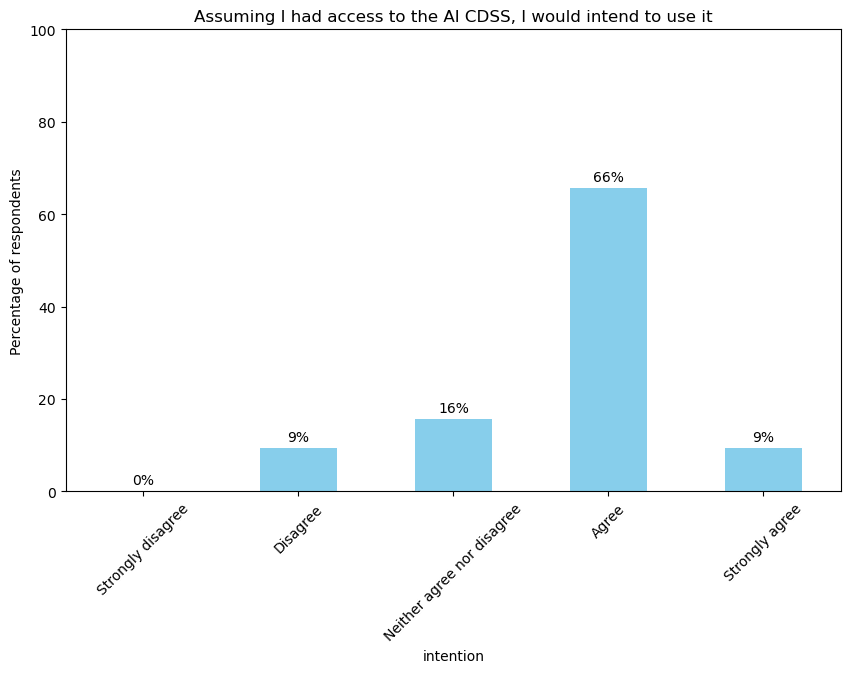

In [33]:
# intention
updated_tam_df['intention'].mean()
updated_tam_df['intention'].std()
anover_kw_test(updated_tam_df, 'intention')
bar_plot(updated_tam_df, 'intention', 'Assuming I had access to the AI CDSS, I would intend to use it')

3.0625

0.6189220598177385

Shapiro test: W-statistic=0.9607539176940918, p-value=0.2880018949508667
Levene's test for user_archetype: W-statistic=0.5084745762711864, p-value=0.48131031574427086
Levene's test for age_new: W-statistic=2.748379403131115, p-value=0.04876215633351208
Levene's test for sex_new: W-statistic=1.6406249999999996, p-value=0.21005362234962044
Levene's test for medical_speciality_new: W-statistic=0.8698468786808009, p-value=0.46836015202622605
Levene's test for grade_new: W-statistic=0.7180851063829786, p-value=0.40348278182976005
Levene's test for ai_familiarity_new: W-statistic=1.3917008663930688, p-value=0.26588714777515376


anova_bool: False



Independant
Kruskal-Wallis for user_archetype: Statistic=1.3438, p-value=0.2464
  -> The differences in user_archetype are ***NOT*** statistically significant.

Kruskal-Wallis for age_new: Statistic=6.2706, p-value=0.1798
  -> The differences in age_new are ***NOT*** statistically significant.

Kruskal-Wallis for sex_new: Statistic=0.0121, p-valu

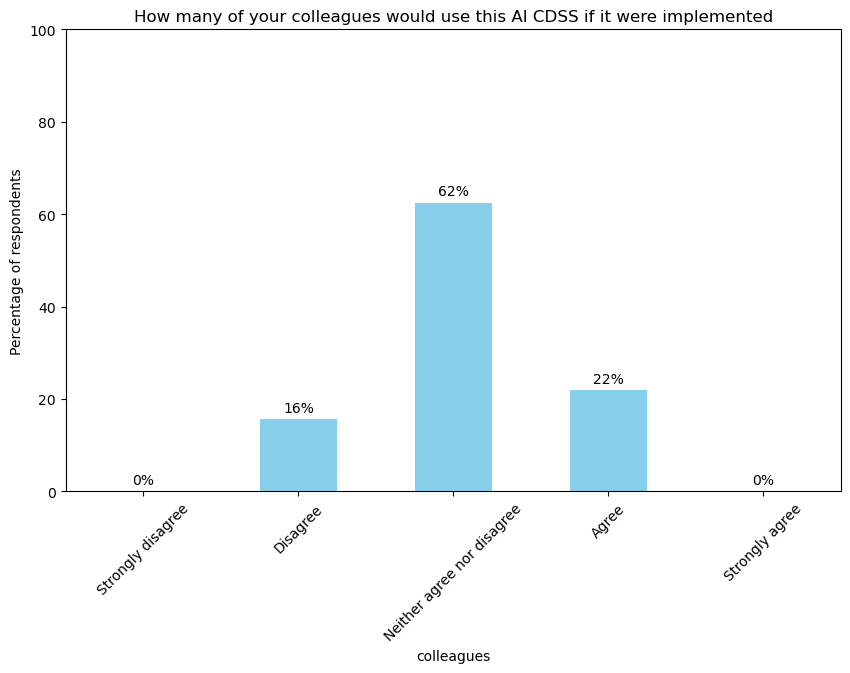

In [34]:
# prestige_image
updated_tam_df['colleagues'].mean()
updated_tam_df['colleagues'].std()
anover_kw_test(updated_tam_df, 'colleagues')
bar_plot(updated_tam_df, 'colleagues', 'How many of your colleagues would use this AI CDSS if it were implemented')

# Old

In [47]:
mardia_test = pg.multivariate_normality(pu_df, alpha=0.05)
print(mardia_test)

HZResults(hz=0.9957092836013285, pval=0.029661972701394965, normal=False)


In [37]:
pg.box_m(data=pu_df.join(demographics[['age', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']]), dvs=['PU1', 'PU2', 'PU3', 'PU4', 'PU5', 'PU6', 'PU7', 'PU8', 'PU9', 'PU10', 'PU11', 'PU12'], group='age')
pg.box_m(data=pu_df.join(demographics[['age', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']]), dvs=['PU1', 'PU2', 'PU3', 'PU4', 'PU5', 'PU6', 'PU7', 'PU8', 'PU9', 'PU10', 'PU11', 'PU12'], group='sex_new')
pg.box_m(data=pu_df.join(demographics[['age', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']]), dvs=['PU1', 'PU2', 'PU3', 'PU4', 'PU5', 'PU6', 'PU7', 'PU8', 'PU9', 'PU10', 'PU11', 'PU12'], group='medical_speciality_new')
pg.box_m(data=pu_df.join(demographics[['age', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']]), dvs=['PU1', 'PU2', 'PU3', 'PU4', 'PU5', 'PU6', 'PU7', 'PU8', 'PU9', 'PU10', 'PU11', 'PU12'], group='grade_new')
pg.box_m(data=pu_df.join(demographics[['age', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']]), dvs=['PU1', 'PU2', 'PU3', 'PU4', 'PU5', 'PU6', 'PU7', 'PU8', 'PU9', 'PU10', 'PU11', 'PU12'], group='ai_familiarity_new')

/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/pandas/core/frame.py:10866: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/pingouin/multivariate.py:386: RuntimeWarning: divide by zero encountered in divide
  c *= (1 / v).sum() - 1 / v.sum()


,Chi2,df,pval,equal_cov
box,NaN,1638.0,NaN,False


,Chi2,df,pval,equal_cov
box,75.593733,78.0,0.556115,True


/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/pingouin/multivariate.py:375: RuntimeWarning: invalid value encountered in power
  M = ((np.linalg.det(covs) / S_det) ** (v / 2)).prod()


,Chi2,df,pval,equal_cov
box,NaN,234.0,NaN,False


/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/pingouin/multivariate.py:375: RuntimeWarning: invalid value encountered in power
  M = ((np.linalg.det(covs) / S_det) ** (v / 2)).prod()


,Chi2,df,pval,equal_cov
box,NaN,78.0,NaN,False


/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/pandas/core/frame.py:10866: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/pingouin/multivariate.py:386: RuntimeWarning: divide by zero encountered in divide
  c *= (1 / v).sum() - 1 / v.sum()


,Chi2,df,pval,equal_cov
box,NaN,234.0,NaN,False


In [27]:
formula

'PU1+PU2+PU3+PU4+PU5+PU6+PU7+PU8+PU9+PU10+PU11+PU12 ~ age + sex_new + medical_speciality_new + grade_new + ai_familiarity_new'

In [26]:
# Prepare the formula for MANOVA
# Include all questionnaire items in the dependent variables section
dependent_vars = '+'.join([f'{i}' for i in pu_df.columns])
formula = f'{dependent_vars} ~ age + sex_new + medical_speciality_new + grade_new + ai_familiarity_new'

manova = MANOVA.from_formula(formula, data=pu_df.join(demographics[['age', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']]))
result = manova.mv_test()

In [29]:
print(result)


                  Multivariate linear model
                                                              
--------------------------------------------------------------
         Intercept        Value   Num DF Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.1534 12.0000 5.0000  2.2992 0.1841
           Pillai's trace 0.8466 12.0000 5.0000  2.2992 0.1841
   Hotelling-Lawley trace 5.5182 12.0000 5.0000  2.2992 0.1841
      Roy's greatest root 5.5182 12.0000 5.0000  2.2992 0.1841
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
          sex_new         Value   Num DF Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.2781 12.0000 5.0000  1.0816 0.5018
           Pillai's trace 0.7219 12.0000 5.0000  1.0816 0.5018
   Hotellin

In [38]:
# Prepare the formula for MANOVA
# Include all questionnaire items in the dependent variables section
dependent_vars = '+'.join([f'{i}' for i in pu_df.columns])
formula = f'{dependent_vars} ~ age + sex_new + medical_speciality_new + grade_new + ai_familiarity_new'

manova = MANOVA.from_formula(formula, data=pu_df.rank().join(demographics[['age', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']]))
result = manova.mv_test()

In [39]:
print(result)

                  Multivariate linear model
                                                              
--------------------------------------------------------------
         Intercept        Value   Num DF Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.2193 12.0000 5.0000  1.4837 0.3489
           Pillai's trace 0.7807 12.0000 5.0000  1.4837 0.3489
   Hotelling-Lawley trace 3.5609 12.0000 5.0000  1.4837 0.3489
      Roy's greatest root 3.5609 12.0000 5.0000  1.4837 0.3489
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
          sex_new         Value   Num DF Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.4661 12.0000 5.0000  0.4774 0.8635
           Pillai's trace 0.5339 12.0000 5.0000  0.4774 0.8635
   Hotellin